In [1]:
#!pip install opencv-python

In [2]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()  # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [4]:
!unzip catanddog.zip -d catanddog/

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [5]:
from torchvision.transforms.transforms import RandomResizedCrop
data_path = 'catanddog/train/'

transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))


385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


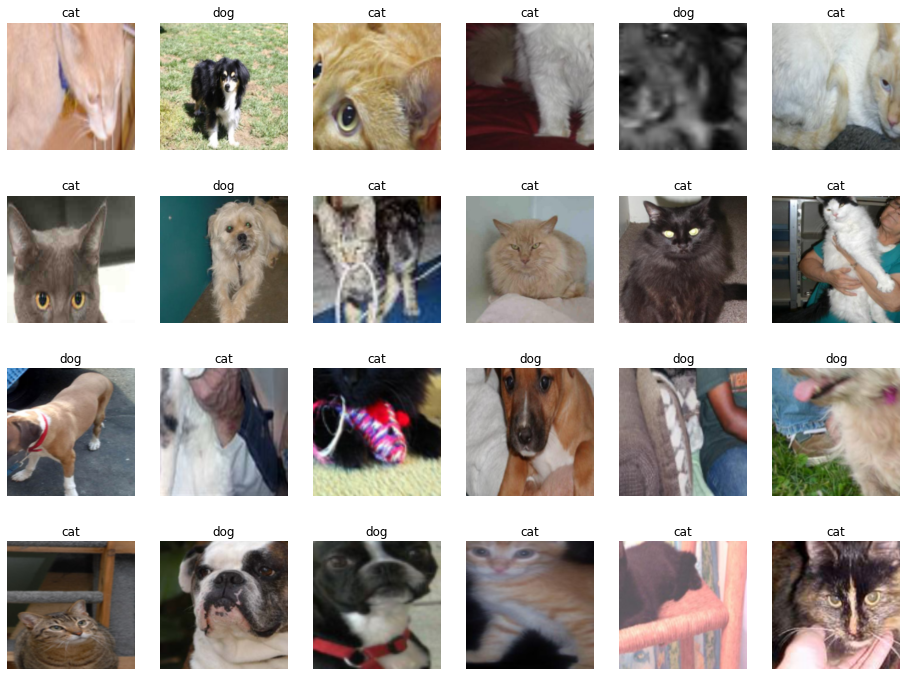

In [6]:
import numpy as np
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [7]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False #역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음 즉. 모델의 일부를 고정 나머지를 학습할때 사용

set_parameter_requires_grad(resnet18)

In [9]:
resnet18.fc = nn.Linear(512,2)

In [10]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): #모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2) 
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실함수 정의
print(model)

fc.weight tensor([[-0.0237, -0.0389, -0.0013,  ..., -0.0028,  0.0433, -0.0283],
        [ 0.0385,  0.0288,  0.0137,  ...,  0.0137, -0.0384, -0.0060]])
fc.bias tensor([-0.0414,  0.0324])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kerne

In [22]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [23]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.2468 Acc: 0.9091

Epoch 1/12
----------
Loss: 0.2056 Acc: 0.9117

Epoch 2/12
----------
Loss: 0.1815 Acc: 0.9221

Epoch 3/12
----------
Loss: 0.1534 Acc: 0.9429

Epoch 4/12
----------
Loss: 0.1347 Acc: 0.9532

Epoch 5/12
----------
Loss: 0.1524 Acc: 0.9403

Epoch 6/12
----------
Loss: 0.2090 Acc: 0.8883

Epoch 7/12
----------
Loss: 0.1429 Acc: 0.9377

Epoch 8/12
----------
Loss: 0.1222 Acc: 0.9636

Epoch 9/12
----------
Loss: 0.1241 Acc: 0.9584

Epoch 10/12
----------
Loss: 0.1044 Acc: 0.9584

Epoch 11/12
----------
Loss: 0.1161 Acc: 0.9558

Epoch 12/12
----------
Loss: 0.1147 Acc: 0.9610

Training complete in 0m 35s
Best Acc: 0.963636


In [25]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
    [
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [26]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [27]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.9592

Loading model catanddog/01.pth
Acc: 0.9184

Loading model catanddog/02.pth
Acc: 0.9592

Loading model catanddog/03.pth
Acc: 0.9592

Loading model catanddog/04.pth
Acc: 0.9592

Loading model catanddog/05.pth
Acc: 0.9388

Loading model catanddog/06.pth
Acc: 0.9592

Loading model catanddog/07.pth
Acc: 0.9592

Loading model catanddog/08.pth
Acc: 0.9490

Loading model catanddog/09.pth
Acc: 0.9592

Loading model catanddog/10.pth
Acc: 0.9592

Loading model catanddog/11.pth
Acc: 0.9592

Loading model catanddog/12.pth
Acc: 0.9592

Validation complete in 0m 11s
Best Acc: 0.959184


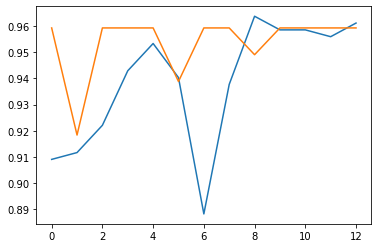

In [28]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

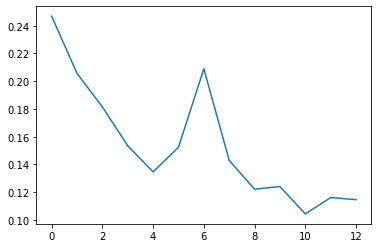

In [29]:
plt.plot(train_loss_hist)
plt.show()

In [32]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

- tensor.clone() : 메모리 새롭개 할당, 계산 그래프에 계속 상주
- tensor.detach() : 공유해서 사용, 계산 그래프에 상주하지 않음
- tensor.clone().detach(): 새롭게 할당, 계산 그래프에 상주하지 않음

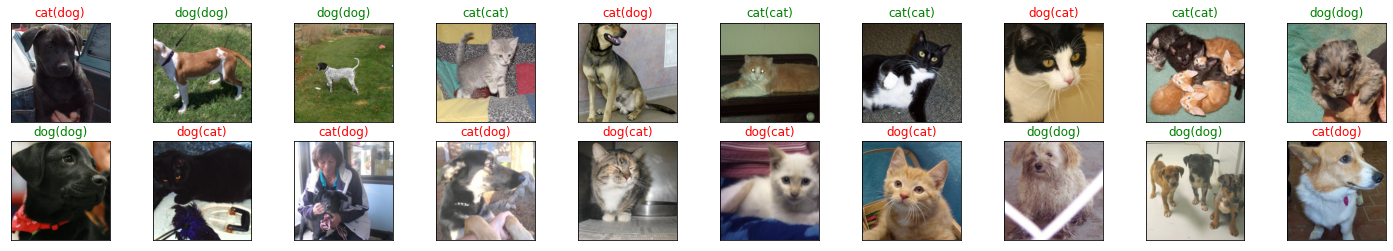

<Figure size 432x288 with 0 Axes>

In [33]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)